# Pocket Monsters
-----

In this notebook I am making visualization of pokemon using SQL queries to pull data from an RDS database and then graphing them to give insights on different questions.

I was very in touch with pokemon when it first came out, but I would like to refresh my knowledge.

In [445]:
%matplotlib inline
plt.rcParams.update({'font.size': 30})
import pandas as pd
import psycopg2
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
from matplotlib import cm

In [446]:
db_info = open('db_info.csv','r').readlines()[0].split(',')
db_dict = {'IP':db_info[0],\
           'PORT':db_info[1],\
           'USER_NAME':db_info[2],\
           'PASSWORD':db_info[3],\
           'DB_NAME':db_info[4]
          }

In [449]:
TABLE_NAME='pocket.monsters'

In [450]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=db_dict['USER_NAME'],
password=db_dict['PASSWORD'],
ipaddress=db_dict['IP'],
port=db_dict['PORT'],
dbname=db_dict['DB_NAME'])) 

In [390]:
conn = create_engine(postgres_str) 

### What kind of information do we have on each pokemon?

In [35]:
SEE_ROW_QUERY = '''SELECT * FROM pocket.monsters LIMIT 5'''
pd.read_sql_query(SEE_ROW_QUERY, conn) 

,name,type1,type2,total,hp,attack,defense,spattack,spdefense,speed,generation,legendary,id
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,1
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,2
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,3
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,3
4,Charmander,Fire,None,309,39,52,43,60,50,65,1,False,4


### What are the different distributions of types?

I know that the type1 and type2 will have different distributions so I will graph both separately.

In [86]:
TYPE_1_COUNT_DATA = 'SELECT type1, count(*) from pocket.monsters GROUP BY type1 ORDER BY count(*) DESC'
type1_df = pd.read_sql_query(TYPE_1_COUNT_DATA, conn) 

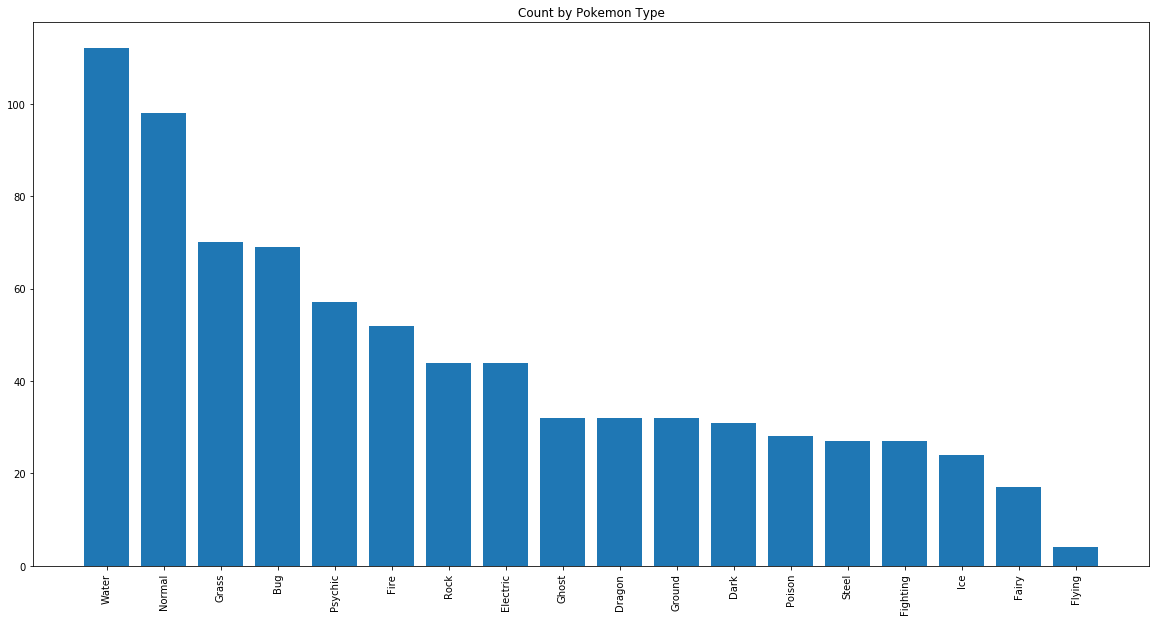

In [438]:
plt.figure(figsize=(20,10))
plt.bar(x=type1_df['type1'],height=type1_df['count'])
plt.xticks(type1_df['type1'].astype(str), rotation='vertical')

plt.title('Count by Pokemon Type')
plt.show()

I find the departure of water types interesting. Perhaps these pokemon have a key role in balancing multiple types.

In [75]:
TYPE_2_COUNT_DATA = 'SELECT type2, count(*) from pocket.monsters GROUP BY type2 ORDER BY count(*) DESC'
type2_df = pd.read_sql_query(TYPE_2_COUNT_DATA, conn) 

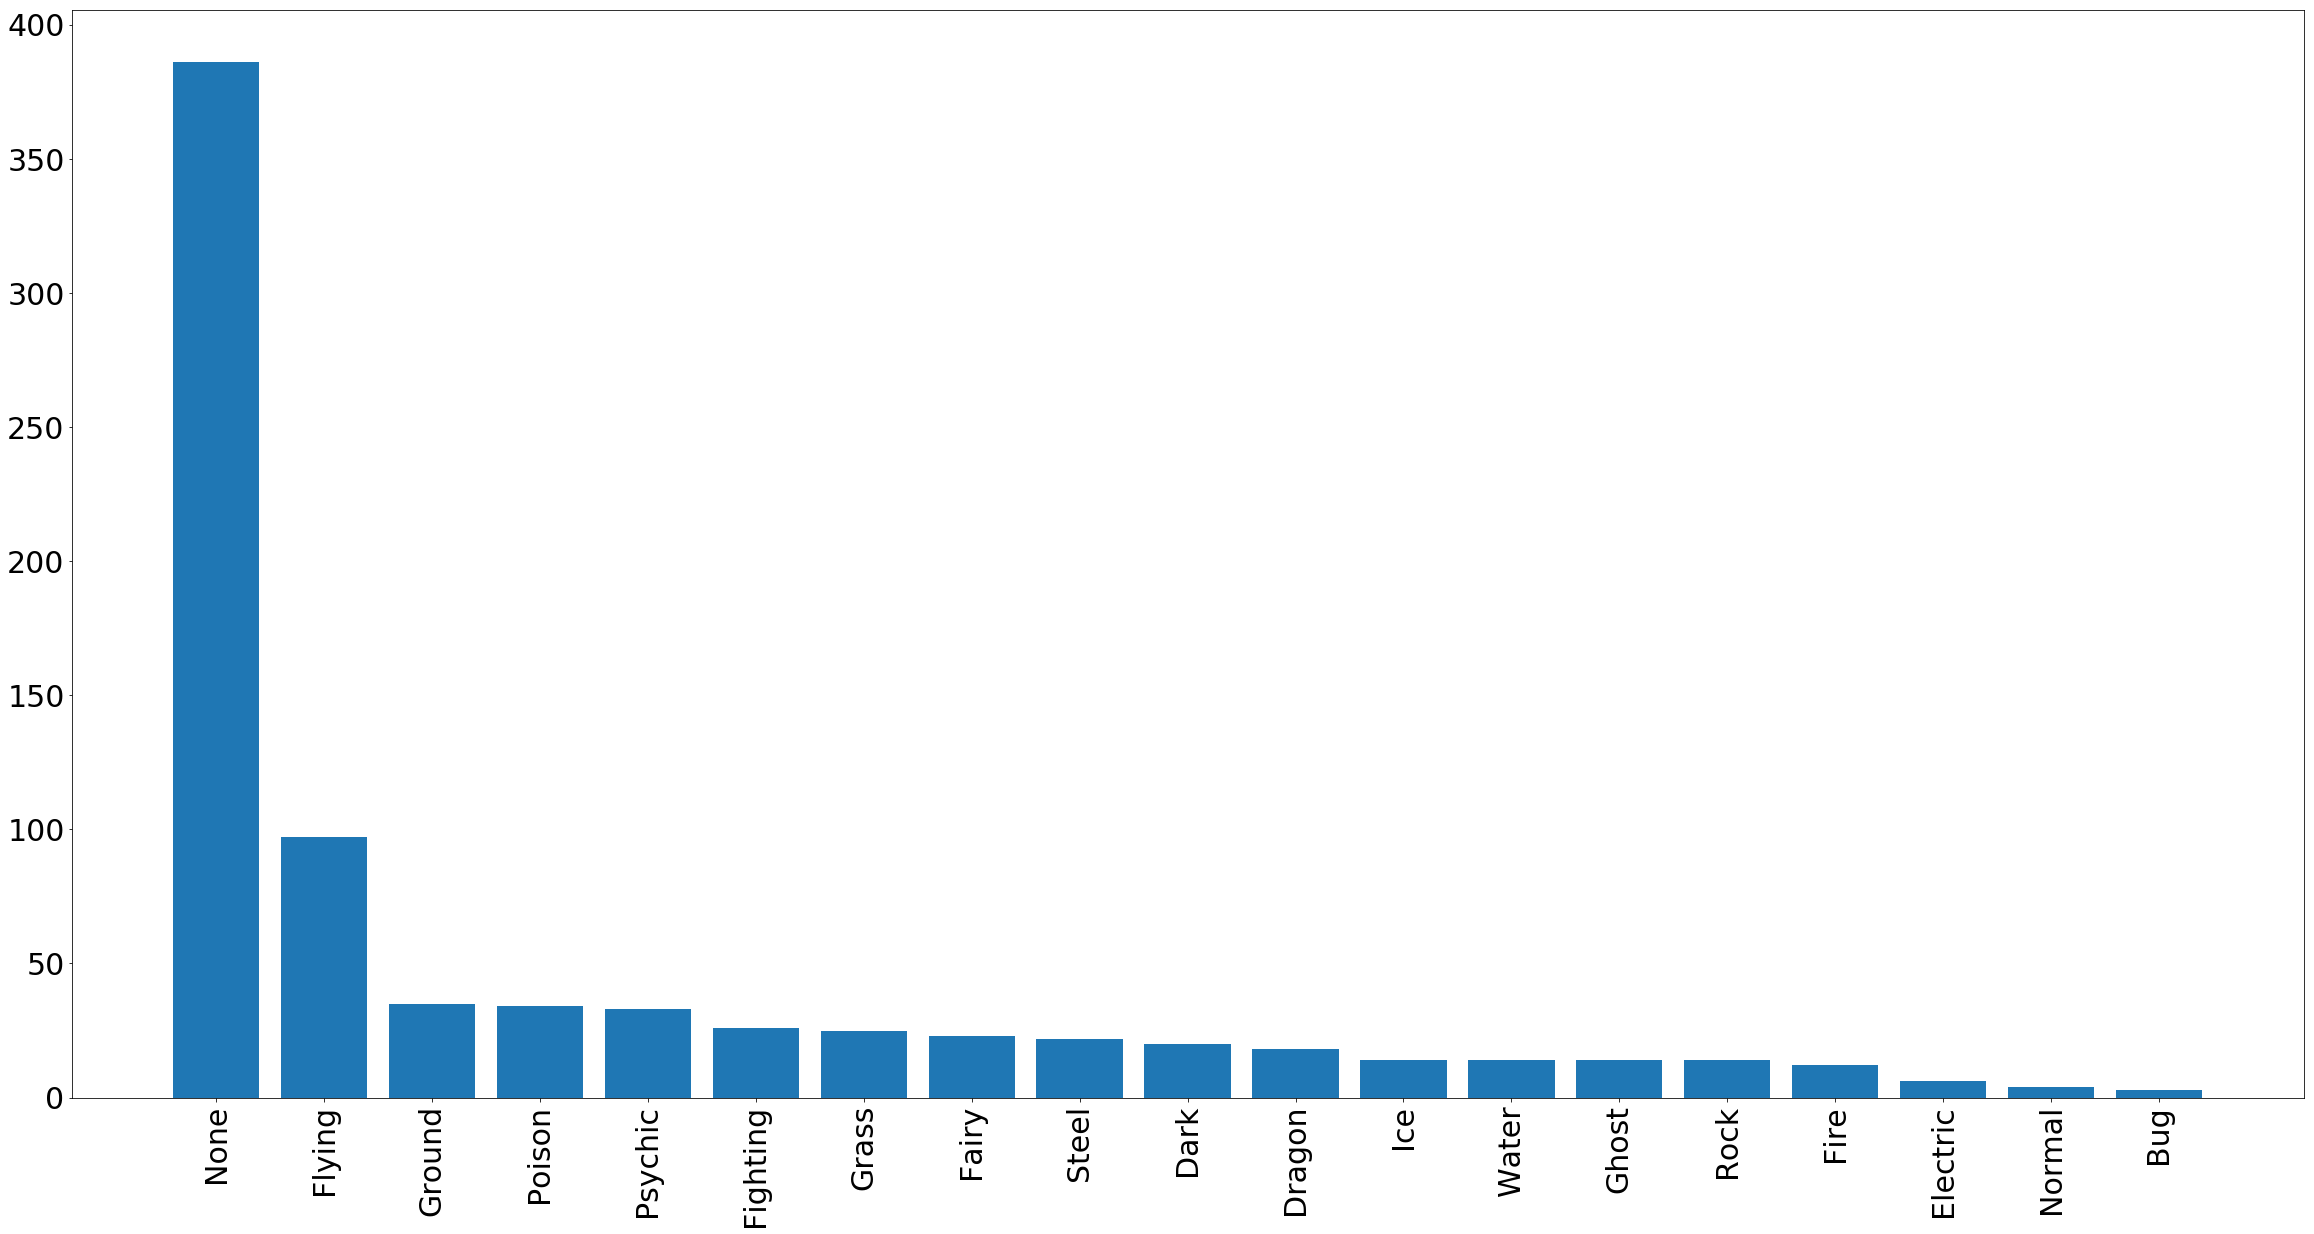

In [91]:
plt.figure(figsize=(40,20))
plt.bar(x=type2_df['type2'].astype(str),height=type2_df['count'])
plt.xticks(type2_df['type2'].astype(str), rotation='vertical')
plt.show()

Clearly type two is an optional attribute. Flying was common 'back in my day' too. Pokemon with this can learn to fly their trainer around in the game, this mechanic is likely still prevalent.

### How many pokemon do they consider legendary?

When I was playing there were 3 legendary birds, Articuno, Flores and Zapdos. Also there was Mew and Mewtwo. I feel like they have introduced more legendaries since then.

In [99]:
LEGENDARY_DATA = 'SELECT count(*) from pocket.monsters WHERE legendary = True'
legendary_df = pd.read_sql_query(LEGENDARY_DATA, conn) 

In [100]:
legendary_df

,count
0,65


65 Legendary pokemon! Nintendo has been busy! I could get side tracked here and just look at how the attributes of legendary pokemon differ from regular pokemon. But I want to analyze the total population's numerical attributes first.

### How are pokemon numerical attributes correlated?

In [101]:
NUMERICAL_DATA = 'SELECT hp, attack, defense, spattack, spdefense,speed from pocket.monsters'
numerical_df = pd.read_sql_query(NUMERICAL_DATA, conn) 

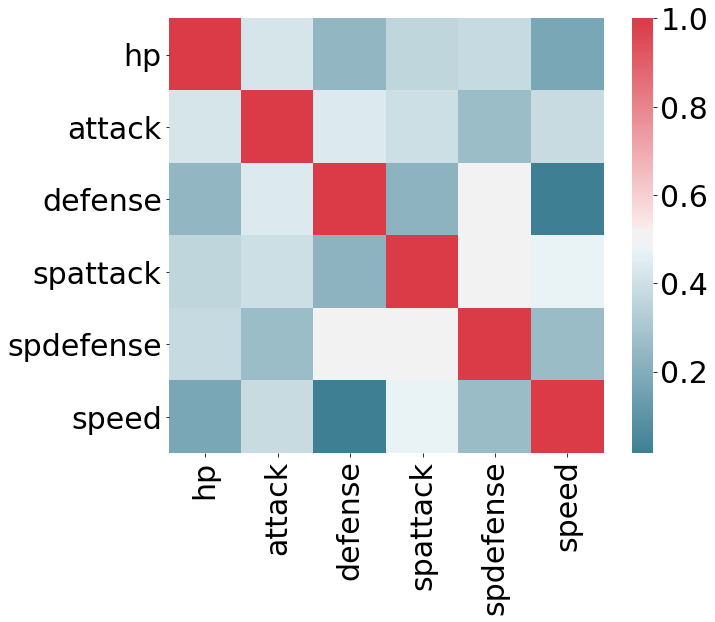

In [118]:
import seaborn as sns
import numpy as np
f, ax = plt.subplots(figsize=(10, 8))
corr = numerical_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

No columns have a negative correlations! This makes sense because it would be quite game breaking if any column was always the polar opposite of another. This would lead to stale gameplay.

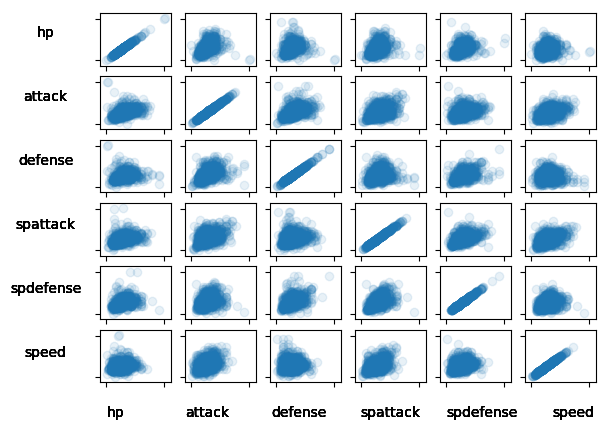

In [183]:
curr_plot_index=1
fig,ax = plt.subplots(6, 6, sharex=True, sharey=True)
for i,col_1 in enumerate(numerical_df.columns):
    for j,col_2 in enumerate(numerical_df.columns):
        curr_ax = ax[i,j]
        curr_ax.scatter(numerical_df[col_1], numerical_df[col_2],alpha=0.1)
        curr_ax.set_yticklabels([])
        curr_ax.set_xticklabels([])
        curr_plot_index+=1
        
        fig.text(i/7+.15, 0.04, col_1, ha='center')
        fig.text(0.04, 0.68-j/7.5+.15, col_2, ha='center', rotation='horizontal')
plt.show()

While there does not appear to any grouping opportunities here, there are certainly some significant departures from the norm. It seems that hp and defense has the most variance with all of the other variables. I think this because there are so many points that are deviant in every plot along the corresponding rows/columns.

I speculate that these are seen as the attributes to capture the difference in the power of the different statistics. So when a Nintendo employee is coming up with the attributes of a new pokemon, if they feel a pokemon is too weak or strong, they'd likely use hp and defense to adjust the total power.

I think that the rest of the attributes are seen as the 'flavor' of a pokemon, or what makes the pokemon seem unique.

### How many pokemon were released with each generation?

In [439]:
GENERATION_DATA = 'SELECT generation, count(*) from pocket.monsters GROUP BY generation ORDER BY generation'
generation_df = pd.read_sql_query(GENERATION_DATA, conn) 

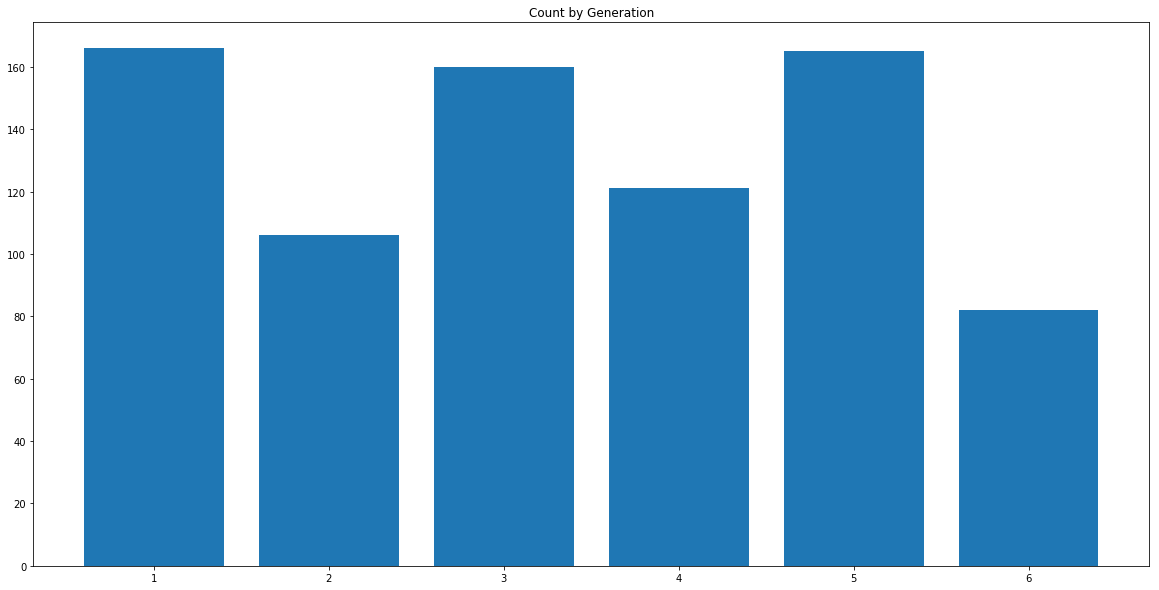

In [440]:
plt.figure(figsize=(20,10))
plt.bar(x=generation_df['generation'].astype(str),height=generation_df['count'])
plt.title('Count by Generation')
plt.xticks(generation_df['generation'].astype(str), rotation='horizontal')
plt.show()

Great Scott! What a collection. I wonder if people still chase the goal of 'catching them all' with that many pokemon. There's certainly an interesting alternating pattern to the generations, I wonder what the cause of that is mostly a business reason or a design decision.

### Is there a power creep?

I'm going to consider a pokemon objectively more powerful for this task if the sum of it's numerical characteristics is greater. A large simplification, but true most of the time I'd say.

In [451]:
POWER_DATA = 'SELECT avg(total) as total, generation from pocket.monsters GROUP BY generation ORDER BY generation'
power_df = pd.read_sql_query(POWER_DATA, conn) 

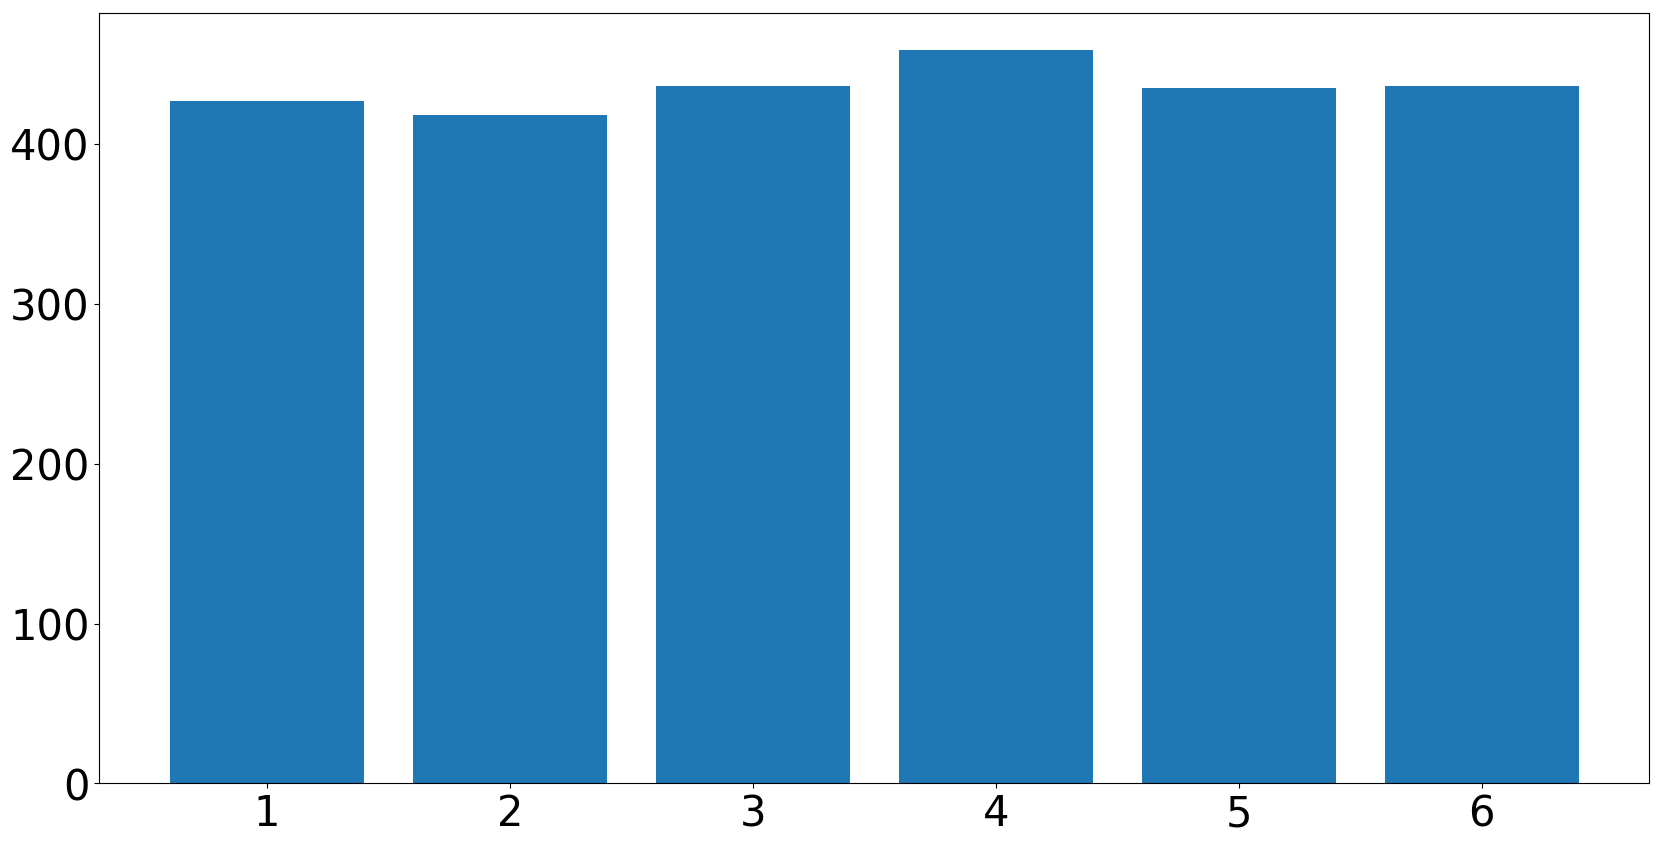

In [209]:
plt.figure(figsize=(20,10))
plt.bar(x=power_df['generation'].astype(str),height=power_df['total'])
plt.xticks(power_df['generation'].astype(str), rotation='horizontal')
plt.title('Sum of Pokemon Statistics by Generation')
plt.show()

Hmm, not very significant I would say. If I am able to move my old pokemon to a new gameboy through some convoluted process, they would likely still stand a chance, good to know!

### Is there a lot of change in the power of specific types from generation to generation

i.e. Have grass pokemon gotten more powerful, but also how do they stack up against these new types

In [431]:
GROUPED_POWER_DATA = '''
SELECT avg(total) as avg, 
        min(total) as min, 
        max(total) as max, 
        stddev(total) as std, 
        percentile_cont(0.75)  WITHIN GROUP (ORDER BY total) as sevenfive_total, 
        percentile_cont(0.25)  WITHIN GROUP (ORDER BY total) as twofive_total,
        generation
    from pocket.monsters 
    GROUP BY generation 
    ORDER BY generation
'''
grouped_power_df = pd.read_sql_query(GROUPED_POWER_DATA, conn) 

In [432]:
grouped_power_df

,avg,min,max,std,sevenfive_total,twofive_total,generation
0,426.813253,195,780,115.878076,500.00,325.0,1
1,418.283019,180,700,120.114133,500.00,330.0,2
2,436.225000,190,780,136.314193,530.00,310.0,3
3,459.016529,194,720,119.556541,530.00,350.0,4
4,434.987879,255,700,108.117934,505.00,328.0,5
5,436.378049,200,700,114.952340,512.25,335.0,6


In [433]:
import numpy as np

import matplotlib.pyplot as plt


avg_dict={}
low_dict={}
high_dict={}
std_dict={}
for generation in grouped_power_df.generation.unique():

        data = grouped_power_df.loc[(grouped_power_df.generation==generation)]
        avg_dict[generation] = int(data['avg'])
        low_dict[generation] = int(data['min'])
        high_dict[generation] = int(data['max'])
        std_dict[generation] = int(data['std'])




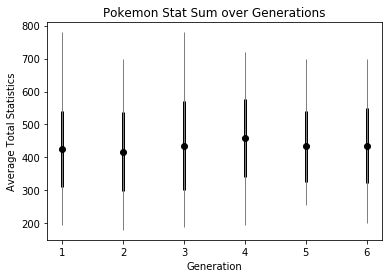

In [435]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots()


ind = np.arange(len(grouped_power_df.generation.unique()))    # the x positions for the Generations
width = 0.1 # width of a bar

for i,generation in enumerate(grouped_power_df.generation.unique()):
    curr_mean = avg_dict[generation]
    curr_low = low_dict[generation]
    curr_high = high_dict[generation]
    curr_std = std_dict[generation]
    
    plt.errorbar(ind[i], curr_mean, curr_std, fmt='ok', lw=3)
    plt.errorbar(ind[i], curr_mean, [[curr_mean - curr_low], [curr_high - curr_mean]],
                 fmt='.k', ecolor='gray', lw=1)
    ax.set_title('Pokemon Stat Sum over Generations')
    ax.set_xticks(ind)
    ax.set_xlabel('Generation')
    ax.set_xticklabels([1,2,3,4,5,6,7])
    ax.set_ylabel('Average Total Statistics')
    ax.autoscale_view()

plt.show()

I don't see an obvious trend across generations, but it looks like there may have been a larger spread in the sum of each pokemon's statistics in generation 3, while the power went down.

In [419]:
TYPE_GROUPED_POWER_DATA = '''
SELECT avg(total) as avg, 
        min(total) as min, 
        max(total) as max, 
        stddev(total) as std, 
        percentile_cont(0.75)  WITHIN GROUP (ORDER BY total) as sevenfive_total, 
        percentile_cont(0.25)  WITHIN GROUP (ORDER BY total) as twofive_total,
        generation,
        type1 
    from pocket.monsters 
    GROUP BY generation,type1 
    ORDER BY generation,type1
'''
grouped_power_df = pd.read_sql_query(TYPE_GROUPED_POWER_DATA, conn) 

avg_dict={}
low_dict={}
high_dict={}
std_dict={}
for generation in grouped_power_df.generation.unique():
    contained_types=grouped_power_df.loc[grouped_power_df.generation==generation].type1.unique()
    
    for poke_type in grouped_power_df.type1.unique():
        if poke_type in contained_types:
            data = grouped_power_df.loc[(grouped_power_df.generation==generation)&(grouped_power_df.type1==poke_type)]
            avg_dict[str(generation)+str(poke_type)] = int(data['avg'])
            low_dict[str(generation)+str(poke_type)] = int(data['min'])
            high_dict[str(generation)+str(poke_type)] = int(data['max'])
            try:
                std_dict[str(generation)+str(poke_type)] = int(data['std'])
            except:
                std_dict[str(generation)+str(poke_type)] = 0

        else:
            avg_dict[str(generation)+str(poke_type)] = 0
            low_dict[str(generation)+str(poke_type)] = 0
            high_dict[str(generation)+str(poke_type)] = 0
            std_dict[str(generation)+str(poke_type)] = 0



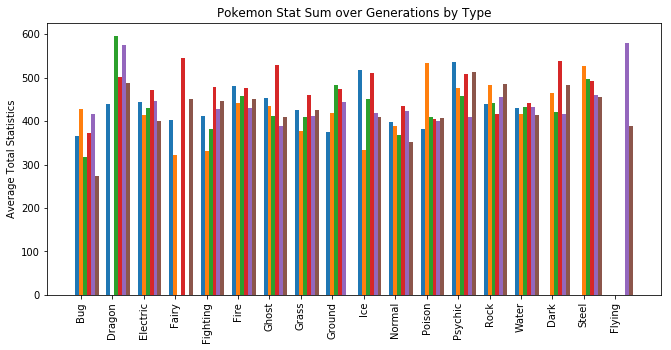

In [420]:
fig, ax = plt.subplots()
fig.set_size_inches((11,5))
ind = np.arange(len(grouped_power_df.type1.unique()))    # the x locations for the groups
width = 0.125
# the width of the bars

for i,generation in enumerate(grouped_power_df.generation.unique()):
    curr_means = np.array([int(avg_dict[str(generation)+str(poke_type)]) for poke_type in grouped_power_df.type1.unique()])
    curr_lows = np.array([int(low_dict[str(generation)+str(poke_type)]) for poke_type in grouped_power_df.type1.unique()])
    curr_highs = np.array([int(high_dict[str(generation)+str(poke_type)]) for poke_type in grouped_power_df.type1.unique()])

    ax.bar(ind+i*width, curr_means, width, bottom=0)
    ax.set_title('Pokemon Stat Sum over Generations by Type')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(grouped_power_df.type1.unique(),rotation='vertical')
    ax.set_ylabel('Average Total Statistics')
    ax.autoscale_view()

plt.show()

I apologize for the busy graph, but I think this is the clearest way to represent the change in a types viability in between generations.

I remembered flying Pokemon but I suppose it was not a type, but now it is! I'd say the variance in absolute power seems to be very different for various types. I'd say this implies to me that they use types to balance each other and are responding to various imbalances.

This EDA obviously does not take into account the strength of the moves which a pokemon has. I would like to investigate this in the future.

Hoped you enjoyed a little pokemon related EDA